<a href="https://colab.research.google.com/github/lj30/DS_tutorials/blob/main/process_mining_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
#!pip install pm4py

In [52]:
# Import the necessary libraries
import pandas as pd
import pm4py
import plotnine
import matplotlib.pyplot as plt # for plots
import datetime
import random
import re
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.wf_net.variants import to_bpmn

In [5]:
#Import data using pm4py xes read files
logs_loans = pm4py.read_xes('BPI Challenge 2017.xes.gz')


/usr/local/lib/python3.9/dist-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [6]:
df = pm4py.convert_to_dataframe(logs_loans)
display("Number of rows: {}".format(len(df)))
display(df.head())

'Number of rows: 1202267'

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202267 entries, 0 to 1202266
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   Action                 1202267 non-null  object             
 1   org:resource           1202267 non-null  object             
 2   concept:name           1202267 non-null  object             
 3   EventOrigin            1202267 non-null  object             
 4   EventID                1202267 non-null  object             
 5   lifecycle:transition   1202267 non-null  object             
 6   time:timestamp         1202267 non-null  datetime64[ns, UTC]
 7   case:LoanGoal          1202267 non-null  object             
 8   case:ApplicationType   1202267 non-null  object             
 9   case:concept:name      1202267 non-null  object             
 10  case:RequestedAmount   1202267 non-null  float64            
 11  FirstWithdrawalAmount  4

In [8]:
# For this example we only care to model the process, so we drop last columns
df = df.drop(['FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'CreditScore', 'OfferedAmount', 'OfferID'], axis=1)


1. What are the possible activities?

In [9]:
display("For the bank loan process the event and activities are the following:")
display(df.drop_duplicates(subset='concept:name')[['EventOrigin', 'concept:name']].sort_values(by='EventOrigin'))

'For the bank loan process the event and activities are the following:'

,EventOrigin,concept:name
0,Application,A_Create Application
218,Application,A_Cancelled
68,Application,A_Denied
38,Application,A_Pending
28,Application,A_Incomplete
15,Application,A_Complete
22,Application,A_Validating
1,Application,A_Submitted
8,Application,A_Accepted
5,Application,A_Concept


In [10]:
# For this example we are not looking for granularity in the bottlenecks, so lets first simplify the activities:
df['new_concept'] = df['concept:name'].where(~df['concept:name'].str.startswith(('A_', 'O_',  'W_')), df['concept:name'].str.slice(start=2))
print("For bank loans the possible activities are:")
display(df.drop_duplicates(subset='new_concept')[["new_concept"]])

For bank loans the possible activities are:


,new_concept
0,Create Application
1,Submitted
2,Handle leads
4,Complete application
5,Concept
8,Accepted
9,Create Offer
10,Created
11,Sent (mail and online)
13,Call after offers


Now, whats out possible identifiers for each application?

In [11]:
print("Our possible identifiers are as follows:")
display(df.groupby(['case:concept:name'])["case:concept:name"].agg(['count']).head())

Our possible identifiers are as follows:


,count
case:concept:name,
Application_1000086665,22
Application_1000158214,25
Application_1000311556,18
Application_1000334415,40
Application_1000339879,51


In [46]:
# you can either filter the DataFrame by 5 specific IDs or select 10 randomly. Try it out!
#selected_ids = ['Application_1000334415', 'Application_1000339879', 'Application_1000311556', 'Application_1000158214', 'Application_1000086665']
selected_ids = random.sample(list(df['case:concept:name'].unique()), 10)
df_sample = df[df['case:concept:name'].isin(selected_ids)]

<ipython-input-47-aeb26380fd9f>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


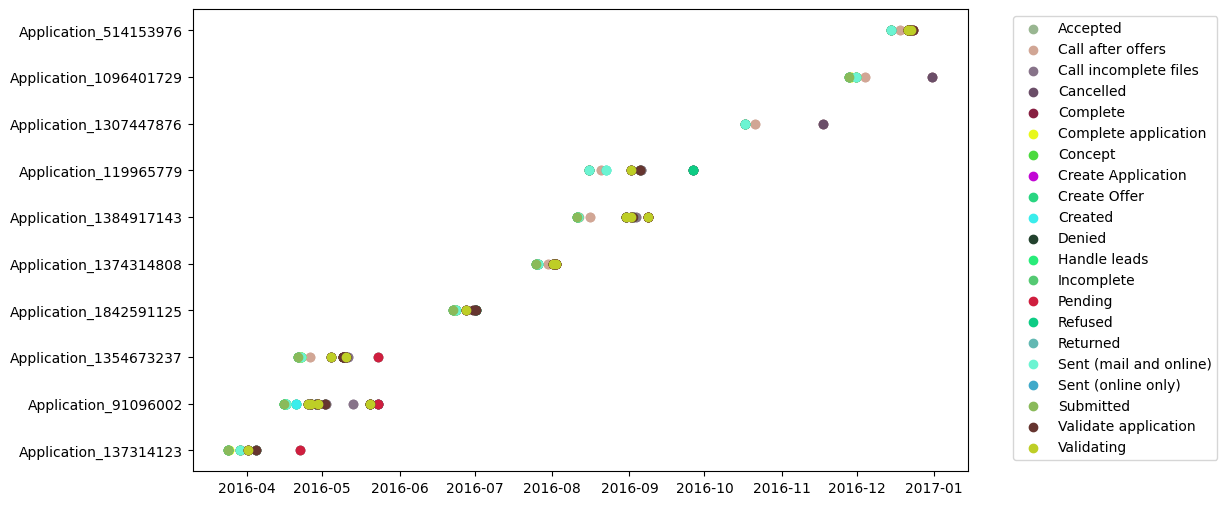

In [47]:
## lets plot the activities for every application to see if we are able to understand the process
activity_color = {}
for activity in df['new_concept'].unique():
    activity_color[activity] = (random.random(), random.random(), random.random())

fig, ax = plt.subplots(figsize=(10, 6))
for activity, group in df_sample.groupby('new_concept'):
    ax.scatter(group['time:timestamp'], group['case:concept:name'], c=activity_color[activity], label=activity)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<ipython-input-63-f4478e096ada>:1: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.


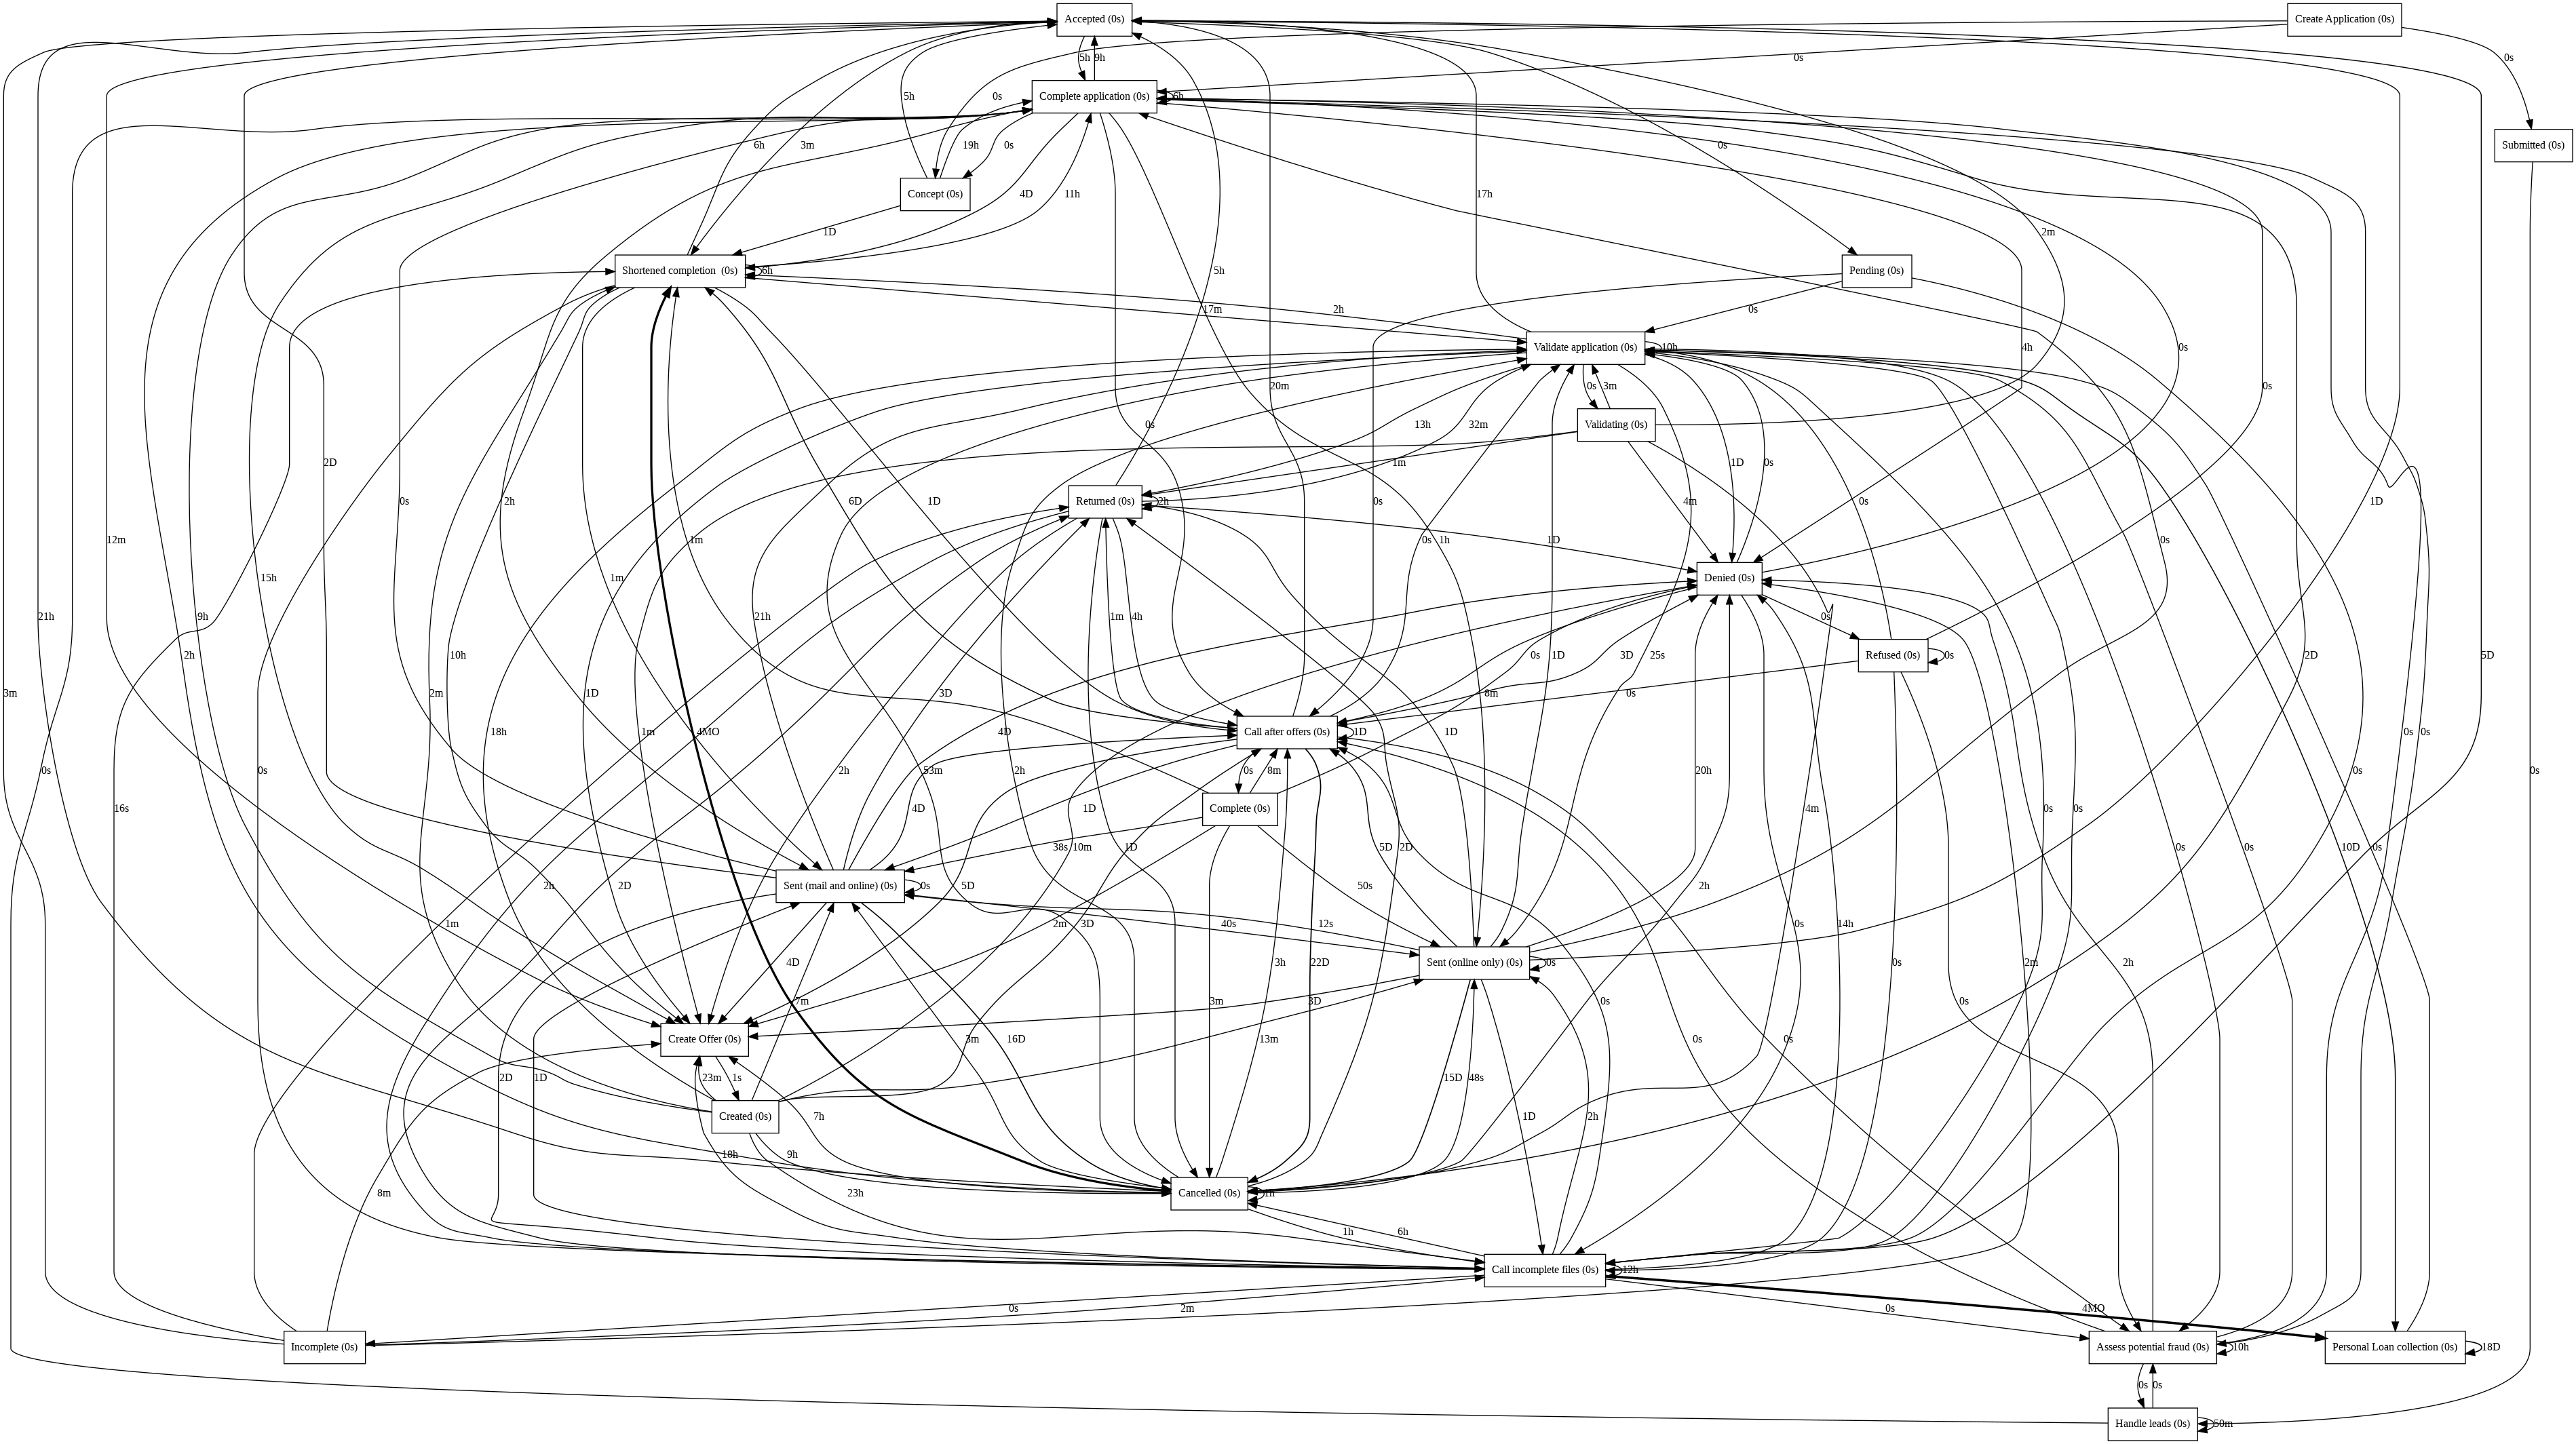

In [63]:
# we define our ids, activities and timestamps to draw the current process
case_log_new = pm4py.format_dataframe(df, case_id='case:concept:name', activity_key='new_concept', timestamp_key='time:timestamp')
case_log_new = pm4py.convert_to_event_log(case_log_new)
dfg = dfg_discovery.apply(case_log_new, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=case_log_new, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

In [61]:
# Find the bottleneck activities in the process based on the DFG, this is a basic example of how to find the values by only looking at the max times
bottleneck_activities = [act for act in dfg if dfg[act] == max(dfg.values())]
# Feel free to zoom at these two activities and compare the timings
print("Bottleneck activities:", bottleneck_activities)

Bottleneck activities: [('Call incomplete files', 'Personal Loan collection')]


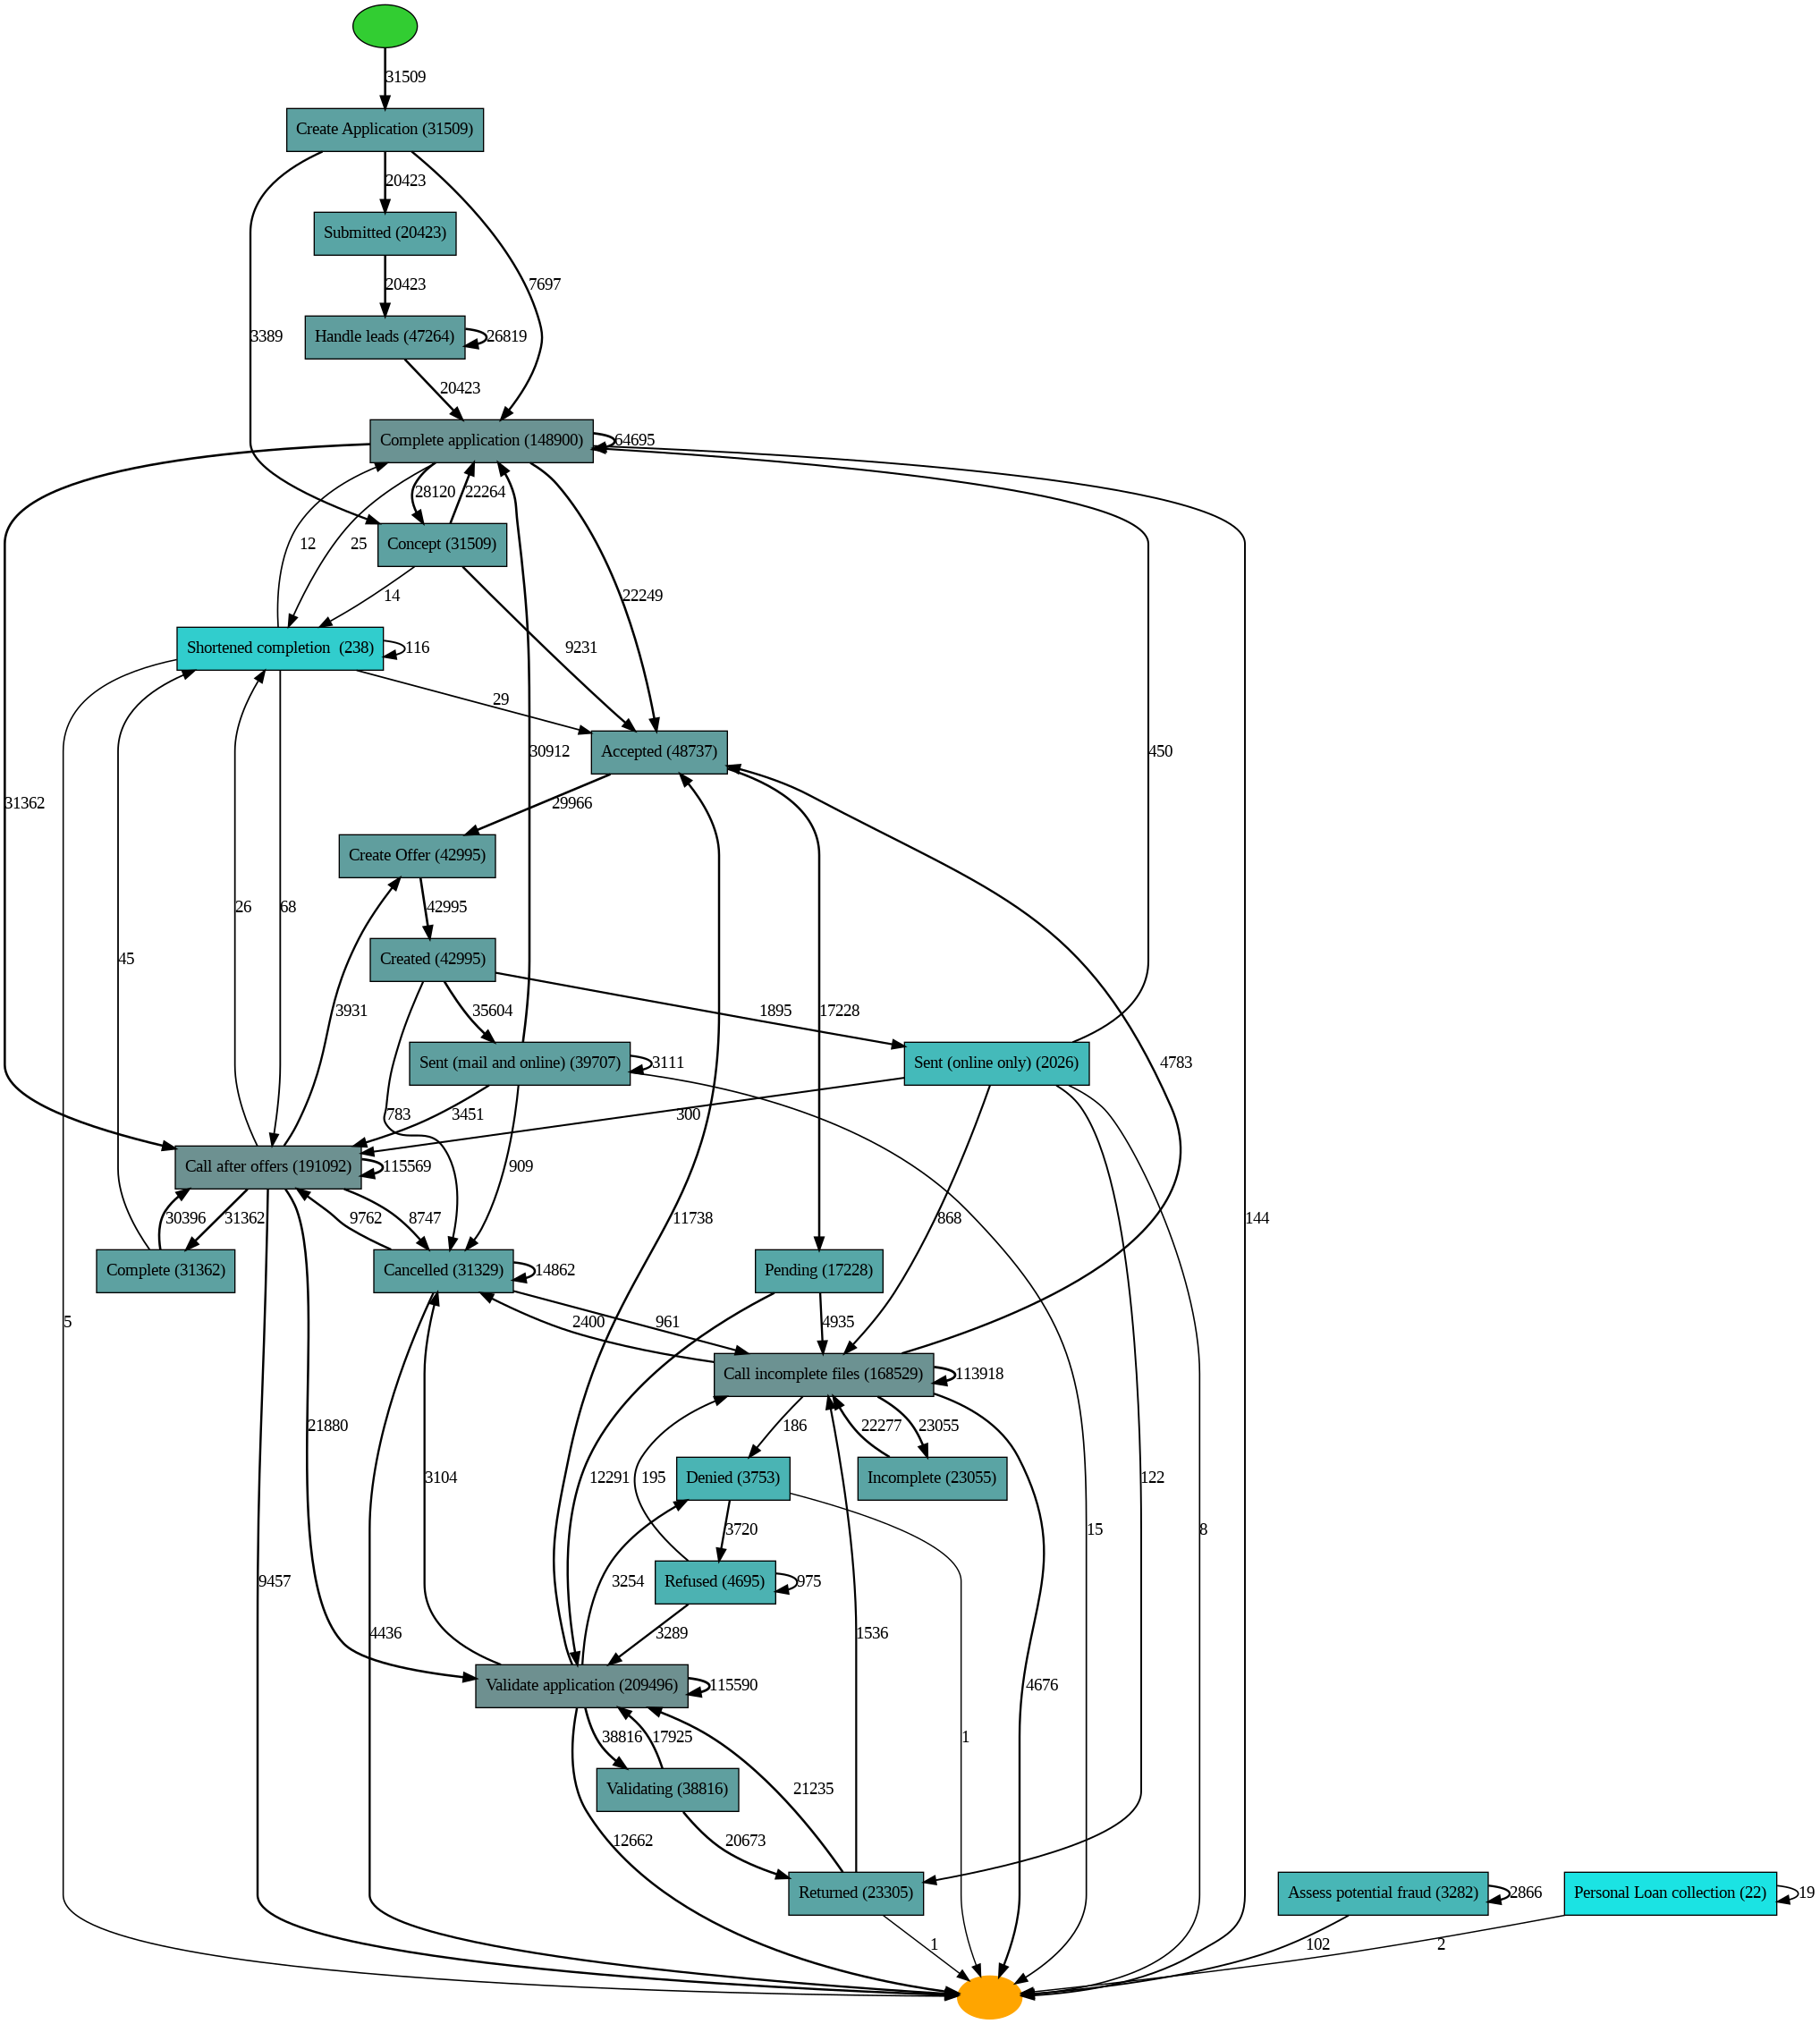

In [51]:

loans_log_event = pm4py.convert_to_event_log(case_log_new)
loans_map = pm4py.discover_heuristics_net(loans_log_event, dependency_threshold = 0.8, and_threshold = 0.5, loop_two_threshold = 0.5)
pm4py.view_heuristics_net(loans_map)

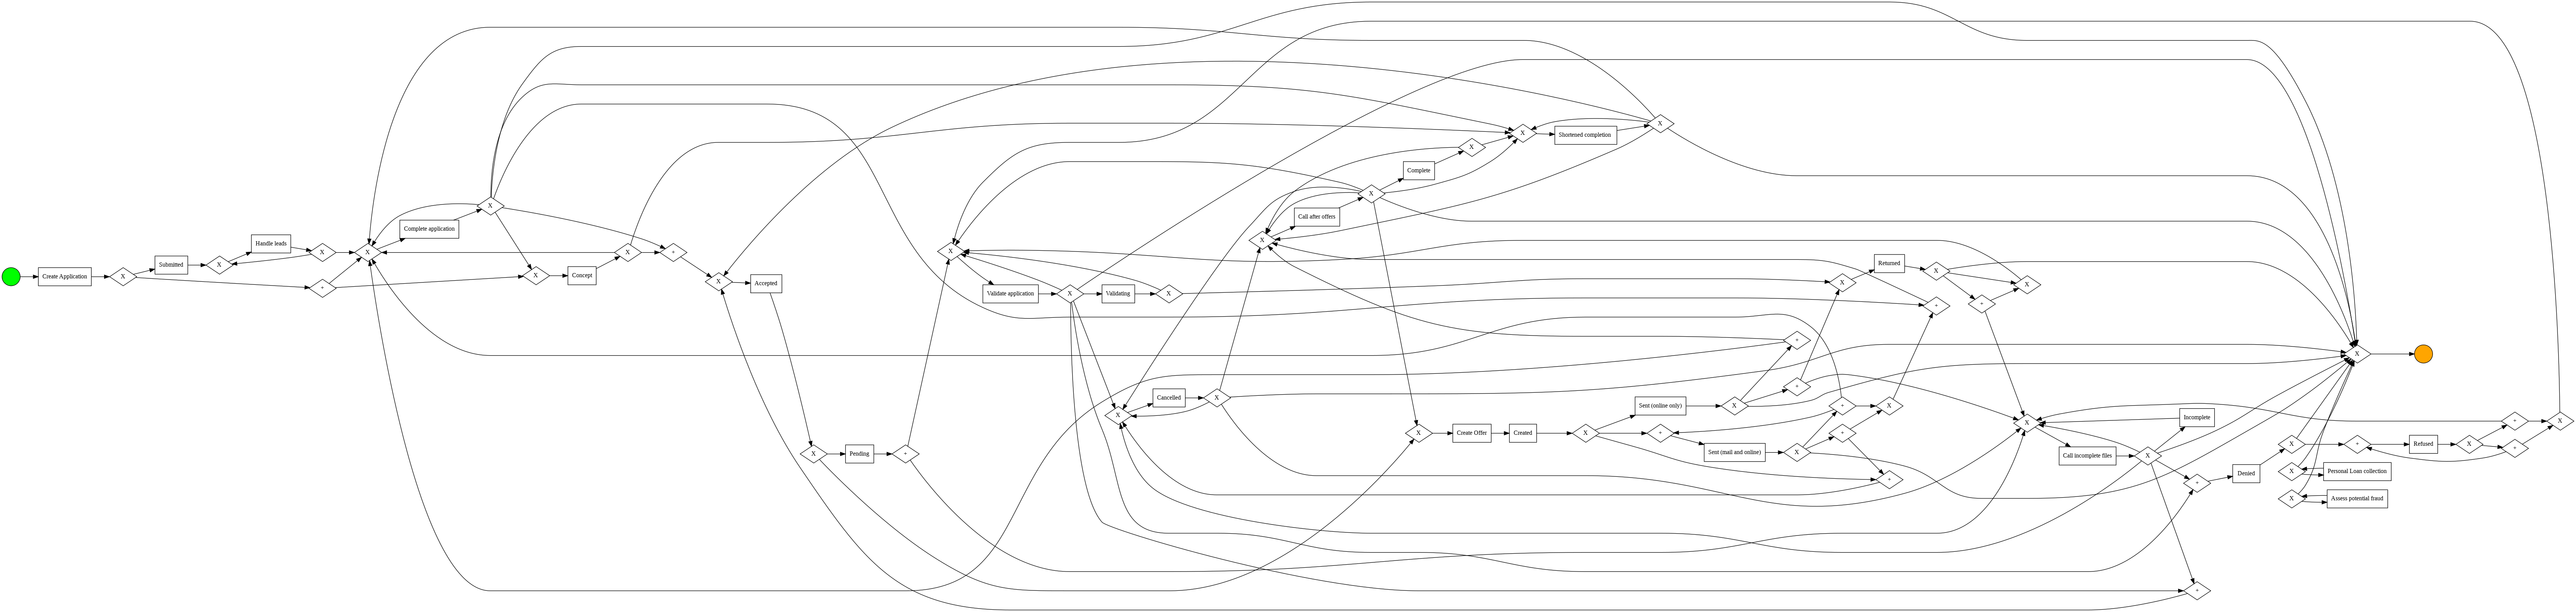

In [54]:
# we need to have an intermediate step to get a Petri net
loans_petrinet, im, fm = pm4py.convert_to_petri_net(loans_map)
loans_bpmn = to_bpmn.apply(loans_petrinet, im, fm)
pm4py.view_bpmn(loans_bpmn)

In [ ]:
# If you are happy with the expected model using expertise knowledge, then you can save the model and compare it with new inputs
#dfg_visualization.save(loans_expected, "dfg.svg"
#dom_alignment = pm4py.conformance_diagnostics_alignments(loans_expected, net, im, fm) 